In [1]:
import ateam.sim.setup.batch_builder as bb
import ateam.sim.setup.default_props as defaults
import ateam.sim.setup as sim
import numpy as np
%matplotlib inline

# Don't use any lists!!
edge_props = {
    'nsyns': 50,
    'syn_weight': 1e-5, 
    'distance_range_min': 0,
    'distance_range_max': 200,
    'delay': 0,
    'target_sections': 'a',
    'dynamics_params': 'AMPA_ExcToExc.json',
    'model_template': 'exp2syn'
}

cell_id = 525133308
# node_props = defaults.cellprops_active(cell_id)
# The above probably won't work, may need to tweak the properties below,
# especially filenames
node_props = {
        'cell_name': cell_id,
        'morphology': '%s.swc' % cell_id,
        'dynamics_params': 'optim_param_%s.json' % cell_id,
        'model_type': 'biophysical',
        'model_template': 'ctdb:Biophys1.hoc',
        'model_processing': 'aibs_allactive'
    }

# Specify the sim folder and the template file (which will set the search path for param files)
folder = './batch_rates'
template = "/allen/aibs/mat/tmchartrand/bmtk_networks/biophys_components_shared/default_config.json"

sm = sim.SimManager.from_template(config_template=template, overwrite=True, sim_folder=folder)

distance_list = np.linspace(0, 350, 5)
interval = 10
linked_edge_props = {'distance_range_min':distance_list, 'distance_range_max':distance_list+interval}

input_props = {'input_rate': np.linspace(1, 4000, 10)}

net = bb.build_batch_all(sm, node_props, edge_props, input_props, n_duplicates=4)

In [2]:
sm.run_bionet_mpi(ncores=4)

NEURON -- VERSION 7.5 master (6b4c19f) 2017-09-25
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2016
See http://neuron.yale.edu/neuron/credits

Additional mechanisms from files
 modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/Kd.mod modfiles/K_P.mod modfiles/K_Pst.mod modfiles/K_T.mod modfiles/K_Tst.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/Nap_Et2.mod modfiles/Nap.mod modfiles/NaTa.mod modfiles/NaTa_t.mod modfiles/NaTg.mod modfiles/NaTs2_t.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/SK.mod modfiles/vecevent.mod
>>> 
>>> 
>>> 
>>> 

numprocs=4
2018-11-30 12:06:24,046 [INFO] Created log file
2018-11-30 12:06:24,046 [INFO] Running NEURON with mpi (4 cores).
2018-11-30 12:06:24,394 [INFO] Building cells.
2018-11-30 12:06:25,855 [INFO] Building recurrent connections
2018-11-30 12:06:25,856 [INFO] Building virtual cell stimulations for input
2018-11-30 12:06:25,898 [INFO] Running simulation 

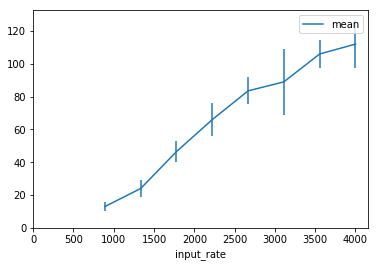

In [4]:
import pandas as pd
import ateam.analysis.spikes as spikes
import matplotlib.pyplot as plt

nodes_df = bb.read_node_props_batch(sm.sim_folder)
nodes_df = nodes_df.join(pd.Series(spikes.get_rates_config(sm.config_path), name='out_rate'))
df_agg = nodes_df.groupby('input_rate').agg(['mean','std'])
df_agg['out_rate'].dropna().plot(y='mean', yerr='std')
plt.axis(xmin=0, ymin=0)
plt.show()

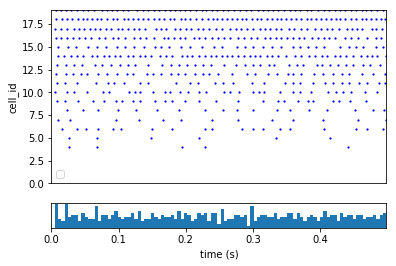

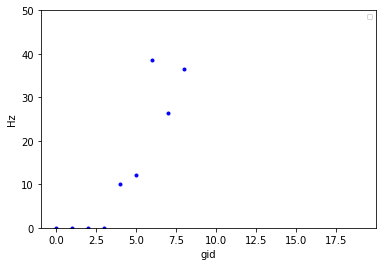

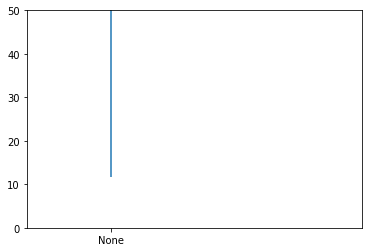

In [2]:
netname = 'batch'
sm.plot_raster(netname)
sm.plot_rates(netname)

In [1]:
# Pseudocode for adding inhibition - NOT TESTED
inh_in = bb.build_input_net_simple(N=1, name='inh_input')
inh_in.build()
net.add_edges(source=input_net.nodes(), target=net.nodes(), iterator='paired', **edge_props_base)
net.build()
sm.add_network(inh_in)
sm.save_network_files()